## MACS30150 PS8 (Question 1)
### Dr. Richard Evans
### Submitted by Junho Choi

Let us import the necessary functions and packages.

In [21]:
import pandas as pd
import numpy as np
import graphviz
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor as RanForReg
from sklearn.ensemble import RandomForestClassifier as RanForCla
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report

Note that this below line of code was necessary for me to create the visualization for the tree graphs; others may have to adjust their PATH.

In [2]:
# os.environ["PATH"] += os.pathsep + 'D:/All/Documents/Graphviz/bin'

## Problem 1

### Problem 1-(a)

Let us first import the dataset from `biden.csv`.

In [22]:
biden = pd.read_csv('biden.csv')

Let us split the data into training ($70\%$) and test ($30\%$) data, as the question directs.

In [23]:
y = biden['biden']
colnames = list(biden.columns)
colnames.remove('biden')
X = biden[colnames]

yvals = y.values
Xvals = X.values

X_tr, X_te, y_tr, y_te = \
    train_test_split(Xvals, yvals, test_size=0.3, random_state=25)

Now, having set the training and test datasets, let us use the `DecisionTreeRegressor` to fit the training data. As directed by the question, we will use the conditions `max_depth=3` and `min_samples_leaf=5`.

In [24]:
dec_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)

In [25]:
dec_tree_tr = dec_tree.fit(X_tr, y_tr)
y_pred = dec_tree_tr.predict(X_te)

Below code will plot the tree graph.

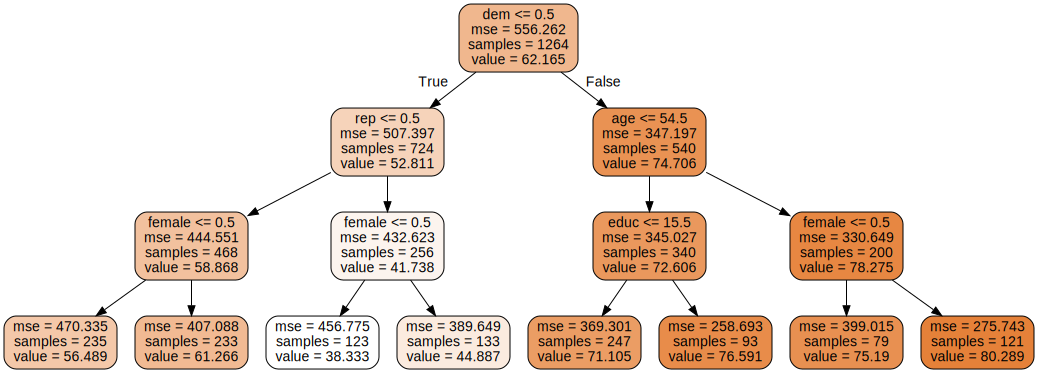

In [26]:
tree_graph = export_graphviz(
    dec_tree,
    out_file=None,
    feature_names=colnames,
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(tree_graph)
graph.render('tree_graph')
graph

Let us now interpret the above result. Each "split" of the nodes are made based on minimization of the mean squared errors (MSE), and the "value" indicates the mean of the warmth for Biden (i.e. the `biden` variable). The first split is made based on the variable `dem` (i.e. whether you are affiliated with Democrats or not). Split to the left, indicating `True` for `dem <= 0.5` is for those who are not affiliated with Democrats; split to the right is. The second set of splits is  made based on the variables `rep` (i.e. Republican affiliation) and `age` for the left and right sub-trees respectively. The third set of splits is made based on the variables `female`, `female`, `educ` (i.e. years of education), and `female`.

Using this information, we can find the end nodes (indicating subgroups) that are likely to be the most and least fervent supporters of Biden. In this dataset's training set, those who are affiliated with Democrats, are older than 54.5, and are female (the rightmost node) have the highest average `biden` value of 80.289; and therefore are the most likely to be supportive of Biden. On the other hand, those who are not affiliated with Democrats, who are affiliated with Republicans, and are not females (the third node from the left) have the lowest average `biden` value of 38.333; and therefore are the least likely to be supportive of Biden.

Finally, we can find the mean squared error of the test set based on the above model fit; it is found to be approximately $396.19$.

In [27]:
MSE_te = (((y_pred - y_te) ** 2).sum())/len(y_pred)
print(MSE_te)

396.193714632


### Problem 1-(b)

Let us conduct the hyperparameter tuning as direct by the question, using the below code chunks.

In [28]:
dec_tree_gen = DecisionTreeRegressor()

param_dist1 = {
    'max_depth': [3, 10],
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(2, 20)
}

In [29]:
random_search1 = \
    RandomizedSearchCV(dec_tree_gen, param_distributions=param_dist1,
                       n_iter=100, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

In [30]:
random_search1.fit(Xvals, yvals)
print('RandBestEstimator1=', random_search1.best_estimator_)
print('RandBestParams1=', random_search1.best_params_)
print('RandBestScore1=', -random_search1.best_score_)

RandBestEstimator1= DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=17,
           min_samples_split=14, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
RandBestParams1= {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}
RandBestScore1= 401.690360223


As seen from the above, the parameters that are calculated to be optimally tuned are `max_depth` being 3, `min_samples_leaf` being 17, and `min_samples_split` being 14. Finally, the MSE of the optimal results are calculated to be approximately $401.69$.

### Problem 1-(c)

As the random forest regression relies on randomness as well, I initialized it with `random_state=25` as well. Using the below set of codes, let us conduct the hyperparameter tuning for random forest regression.

In [31]:
rfr_gen = RanForReg(random_state=25)

param_dist2 = {
    'n_estimators': [10, 200],
    'max_depth': [3, 10],
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(2, 20),
    'max_features': sp_randint(1, 5)
}

In [32]:
random_search2 = \
    RandomizedSearchCV(rfr_gen, param_distributions=param_dist2,
                       n_iter=100, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

In [33]:
random_search2.fit(Xvals, yvals)
print('RandBestEstimator2=', random_search2.best_estimator_)
print('RandBestParams2=', random_search2.best_params_)
print('RandBestScore2=', -random_search2.best_score_)

RandBestEstimator2= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=17,
           min_samples_split=13, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=25,
           verbose=0, warm_start=False)
RandBestParams2= {'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 17, 'min_samples_split': 13, 'n_estimators': 10}
RandBestScore2= 397.068109012


Based on the above results, it is possible to find out of optimal tuning parameter values. They are as follows: `max_depth` being 3, `max_features` being 2, `min_samples_leaf` being 17, `min_samples_split` being 13, `n_estimators` being 10. The MSE of the optimal results can be calculated as being approximately $397.07$.